In [6]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install pycountry
!pip install fuzzywuzzy
!pip install import_ipynb
!pip install movecolumn

In [8]:
import os
import import_ipynb

import glob
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import movecolumn as mc

from fuzzywuzzy import process, fuzz
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
%cd "/content/drive/MyDrive/Shared Projects/Project_Happiness/utils"

/content/drive/MyDrive/Shared Projects/Project_Happiness/utils


In [10]:
import constants

importing Jupyter notebook from constants.ipynb
Stored 'constants_unique_countries' (list)
Stored 'constants_fuzzy_matches' (dict)
Stored 'constants_geopands' (dict)


In [11]:
execfile('cleanup_helpers.py')

In [12]:
%store -r constants_unique_countries constants_fuzzy_matches

In [13]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)

In [14]:
## Matching fuzzy country matches from the unique countries list to the countries in the countries features for all df
def update_all_dfs_with_fuzzy_matches_key(dfs_dict, fuzzy_dict_ref):

    for year, df in dfs_dict.items():
        df = add_fuzzy_matches_key_column(df, fuzzy_dict_ref, 'fuzzy_matches_key')
        dfs_dict[year] = df

    return dfs_dict

In [15]:
## Cleaning wrong formatting in columns of interest

def convert_to_float(df):

    for column in df.columns:
        if column not in ['Country', 'fuzzy_matches_key']:
            df[column] = df[column].str.replace(',', '.').astype(float)

    return df

In [16]:
## Removing the observations with missing values

def drop_na_rows(dfs_dict):

    for year, df in dfs_dict.items():
        dfs_dict[year] = df.dropna(subset=['fuzzy_matches_key'])

    return dfs_dict

In [17]:
## locating duplicates within the all df dict

def identify_duplicate_rows(dfs_dict):
    duplicates_dict = {}

    for year, df in dfs_dict.items():
        duplicates = df[df['fuzzy_matches_key'].duplicated(keep=False)]
        if not duplicates.empty:
            duplicates_dict[year] = duplicates

    return duplicates_dict

In [18]:
## For the found duplicated rows average between the 2 rows is calculated and then duplicated observations are dropped and replaced with the calculated averages

def average_and_remove_duplicates(dfs_dict):
    updated_dfs = {}

    for year, df in dfs_dict.items():
        while df['fuzzy_matches_key'].duplicated().any():

            duplicated_keys = df[df['fuzzy_matches_key'].duplicated(keep=False)]['fuzzy_matches_key'].unique()

            for key in duplicated_keys:
                dup_rows = df[df['fuzzy_matches_key'] == key]
                mean_values = dup_rows[['Score_' + str(year)]].mean()
                mean_values['Country'] = dup_rows['Country'].iloc[0]
                mean_values['fuzzy_matches_key'] = key
                df = df[df['fuzzy_matches_key'] != key]
                df = pd.concat([df, pd.DataFrame([mean_values])], ignore_index=True)

        updated_dfs[year] = df

    return updated_dfs

In [19]:
## Merge all df from the dictionary on the unique countries list into one df

def merge_all_dfs(dfs_dict):
    merged_df = dfs_dict[list(dfs_dict.keys())[0]]

    for year, df in list(dfs_dict.items())[1:]:
        if 'Country' in df.columns:
            df = df.rename(columns={'Country': f'Country_{year}'})
        merged_df = merged_df.merge(df, on='fuzzy_matches_key', how='outer')

    return merged_df

In [20]:
## Renaming the new countries column

def clean_merged_df(merged_df):

    columns_to_keep = [col for col in merged_df.columns if not col.startswith('Country')]
    cleaned_df = merged_df[columns_to_keep]
    cleaned_df = cleaned_df.rename(columns={'fuzzy_matches_key': 'unique countries'})

    return cleaned_df

In [21]:
## Filling missing values for Namibia with average of the next 2 years

def fill_missing_values_2015(df):

    df_filled = df.copy()

    mask = df_filled[['Score_2015']].isnull().all(axis=1)
    indices_with_nan = df_filled[mask].index

    for index in indices_with_nan:
        df_filled.loc[index, 'Score_2015'] = np.mean([df_filled.loc[index, 'Score_2016'], df_filled.loc[index, 'Score_2017']])

    df_filled_2 = df_filled

    return df_filled

In [22]:
def lin_reg(df: pd.DataFrame, year: int, years: np.array) -> pd.DataFrame:
  years_reshaped = years.reshape(-1, 1)
  predicted_scores_year = []

  for index, row in df.iterrows():
    scores = row.iloc[1:].values
    linear_regr = LinearRegression()
    linear_regr.fit(years_reshaped, scores)
    year_array = np.array([[year]])
    predicted_score_per_year = linear_regr.predict(year_array)[0]
    predicted_scores_year.append(predicted_score_per_year)

  df2 = pd.concat([df, pd.Series(predicted_scores_year, name=f'Score_{year}')], axis=1)

  return df2

In [23]:
def ranking_scores(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  for col in df_copy.columns[1:]:
    df_copy[f'rank_{col}'] = df_copy[col].rank(ascending=False).astype(int)
  return df_copy

In [24]:
## Local folder where datafiles are stored
data_path = '/content/drive/MyDrive/Shared Projects/Project_Happiness/data/happiness_score_2015_2022'


## Years of interest
years = range(2015, 2023)

## Dict with the unique countries containing the name variants within the dataframes
fuzzy_dict_ref = constants_fuzzy_matches

dfs_dict = import_all_dfs(years, data_path)
dfs_dict_temp = rename_and_retain_cols_for_all_dfs(dfs_dict)
dfs_dict_temp_2 = update_all_dfs_with_fuzzy_matches_key(dfs_dict_temp, fuzzy_dict_ref)

dfs_dict[2022] = convert_to_float(dfs_dict[2022])
dfs_dict_cleaned = drop_na_rows(dfs_dict)

duplicated_rows_dict = identify_duplicate_rows(dfs_dict_cleaned)
updated_dfs = average_and_remove_duplicates(dfs_dict_cleaned)

merged_dataframe = merge_all_dfs(updated_dfs)
cleaned_dataframe = clean_merged_df(merged_dataframe)


filled_dataframe_2015 = fill_missing_values_2015(cleaned_dataframe)

cleaned_df = mc.MoveTo2(filled_dataframe_2015,'Score_2015')

cleaned_df
cleaned_df.drop([135], axis=0, inplace=True)
cleaned_df.reset_index(drop=True, inplace=True)

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.base.Index'>


In [25]:
cleaned_df

,unique countries,Score_2015,Score_2016,Score_2017,Score_2018,Score_2019,Score_2020,Score_2021,Score_2022
0,Switzerland,7.587,7.5090,7.4940,7.4870,7.480,7.55990,7.5710,7.512
1,Iceland,7.561,7.5010,7.5040,7.4950,7.494,7.50450,7.5540,7.557
2,Denmark,7.527,7.5260,7.5220,7.5550,7.600,7.64560,7.6200,7.636
3,Norway,7.522,7.4980,7.5370,7.5940,7.554,7.48800,7.3920,7.365
4,Canada,7.427,7.4040,7.3160,7.3280,7.278,7.23210,7.1030,7.025
...,...,...,...,...,...,...,...,...,...
133,Benin,3.340,3.4840,3.6570,4.1410,4.883,5.21600,5.0450,4.623
134,Togo,2.839,3.3030,3.4950,3.9990,4.085,4.18720,4.1070,4.112
135,Cyprus,5.692,5.6585,5.7155,5.7985,5.882,5.84725,5.8795,5.844
136,Congo,4.253,4.2540,4.2855,4.4020,4.615,4.75270,5.3420,5.075


In [26]:
# fixed_df = cleaned_df.reset_index(drop=True)
# temp2 = fixed_df.drop(columns=[col for col in fixed_df.columns if isinstance(col, str) and col.startswith("Corruption")])
# temp3 = temp2.drop(columns=[col for col in fixed_df.columns if isinstance(col, str) and col.startswith("GDP_PC_")])
# temp4 = temp3.drop(columns=[col for col in fixed_df.columns if isinstance(col, str) and col.startswith("rank_")])

In [27]:
years_lr = np.array(range(2015, 2028))

In [28]:
subset_lr_2023 = lin_reg(cleaned_df, 2023, years_lr[:-5])

In [29]:
subset_lr_2023

,unique countries,Score_2015,Score_2016,Score_2017,Score_2018,Score_2019,Score_2020,Score_2021,Score_2022,Score_2023
0,Switzerland,7.587,7.5090,7.4940,7.4870,7.480,7.55990,7.5710,7.512,7.523686
1,Iceland,7.561,7.5010,7.5040,7.4950,7.494,7.50450,7.5540,7.557,7.534036
2,Denmark,7.527,7.5260,7.5220,7.5550,7.600,7.64560,7.6200,7.636,7.667279
3,Norway,7.522,7.4980,7.5370,7.5940,7.554,7.48800,7.3920,7.365,7.396464
4,Canada,7.427,7.4040,7.3160,7.3280,7.278,7.23210,7.1030,7.025,7.016600
...,...,...,...,...,...,...,...,...,...,...
133,Benin,3.340,3.4840,3.6570,4.1410,4.883,5.21600,5.0450,4.623,5.488179
134,Togo,2.839,3.3030,3.4950,3.9990,4.085,4.18720,4.1070,4.112,4.574486
135,Cyprus,5.692,5.6585,5.7155,5.7985,5.882,5.84725,5.8795,5.844,5.931500
136,Congo,4.253,4.2540,4.2855,4.4020,4.615,4.75270,5.3420,5.075,5.308575


In [30]:
subset_lr_2024 = lin_reg(subset_lr_2023, 2024, years_lr[:-4])

In [31]:
subset_lr_2025 = lin_reg(subset_lr_2024, 2025, years_lr[:-3])

In [32]:
subset_lr_2026 = lin_reg(subset_lr_2025, 2026, years_lr[:-2])

In [33]:
subset_lr_2027 = lin_reg(subset_lr_2026, 2027, years_lr[:-1])

In [34]:
subset_lr_2028 = lin_reg(subset_lr_2027, 2028, years_lr)

In [35]:
ranked_lr_df= ranking_scores(subset_lr_2028)

In [37]:
%store ranked_lr_df

Stored 'ranked_lr_df' (DataFrame)


###Imported Visualizations from the visualizations notebook

In [45]:
# Load the figure
with open('/content/drive/MyDrive/Shared Projects/Project_Happiness/utils/fig_1.pkl', 'rb') as f:
    fig_01 = pickle.load(f)

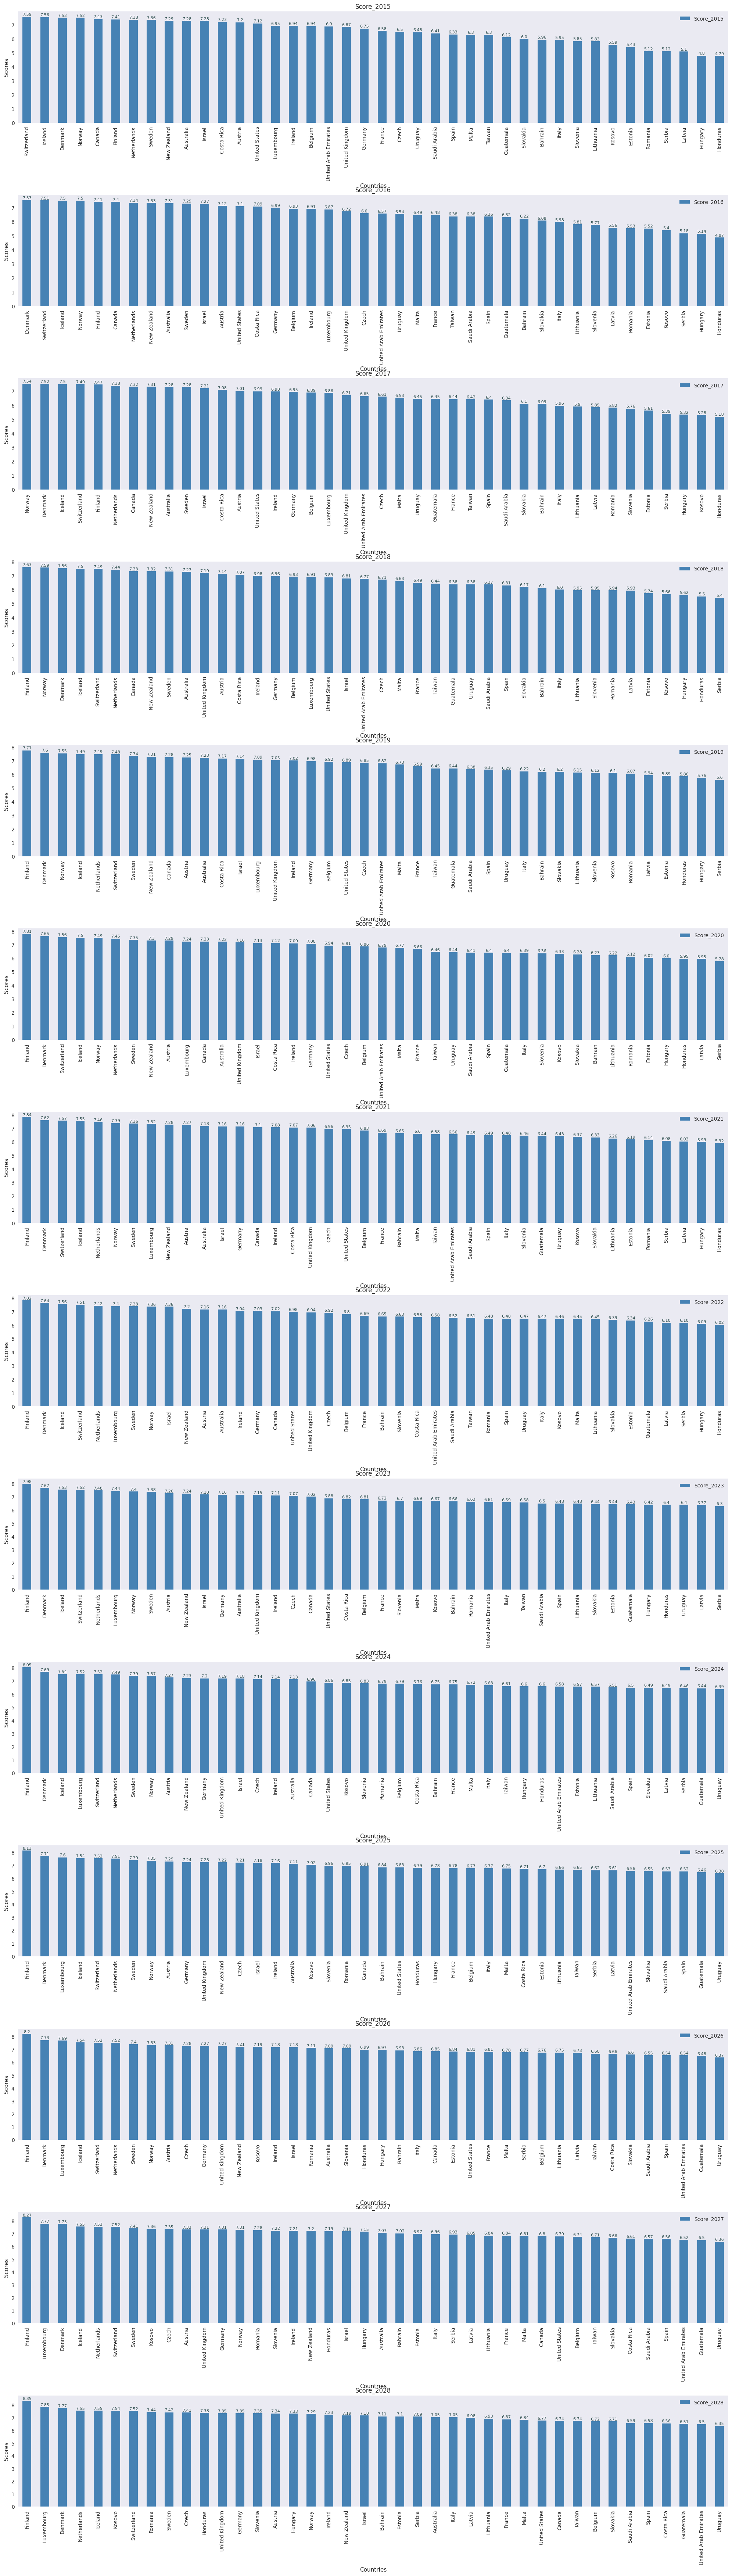

In [46]:
fig_01

In [49]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load the figure
with open('/content/drive/MyDrive/Shared Projects/Project_Happiness/utils/video.pkl', 'rb') as f:
    video_01 = pickle.load(f)

In [51]:
HTML(video_01)

In [52]:
import plotly.io as pio
# Load the figure
with open('/content/drive/MyDrive/Shared Projects/Project_Happiness/utils/interactive_map.pkl', 'rb') as f:
    interactive_map_01 = pickle.load(f)

In [53]:
interactive_map_01.show()